# Load Packages #

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
from skimage.draw import circle_perimeter
from math import sqrt
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import threshold_otsu
from tabulate import tabulate
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.image as mpimg
from matplotlib import rcParams
import h5py    # for reading HDF5 files 
import cv2     # for image conversion
import re    # use it to sort but not sure what it is!
from scipy.stats import zscore
from skimage import draw, measure
import pywt
from scipy.spatial.distance import cdist
import seaborn as sns
from scipy.stats import multivariate_normal
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import threshold_otsu
from skimage import color
import glob

# Data extraction #

### Data set infromation overview: ###

1. Divergent Sets:

    Consists of 12 genotypically distinct strains. These are strains that are further apart on the phenotypic tree. 
    Ideal for determining broad-sense heritability with repeated measurements of specific phenotypes.
    This allows us to look into the relationship between the behavior and the genetic makeup. 

2. Mapping Sets:

    Comprises 48 strains suitable for collecting phenotype data for broad diversity or genome-wide association studies.
    Using multiple strain sets can enhance the statistical strength in genome-wide association studies.

### Pipline: ###

1. Take hdf5 tierpsy output and extract frames

ATTENTION: change the output_root_path depending on which data set you are using 

In [2]:
def extract_label_from_path(file_path):
    # Get the base file name
    base_name = os.path.basename(file_path)
    
    try:
        # Find the position of the first underscore after the 6th character
        first_underscore_pos = base_name.index('_', 6)
        
        # Extract the label from the 6th character to the first underscore
        label_strain = base_name[6:first_underscore_pos]
        
        return label_strain
    except ValueError:
        return "Unknown"

### Accessing single strains all videos ###

1. Keeping all frames sepearated

2. Putting all frames from all videos in same folder for analysis 

Extract frames from each hdf5 file: 


This code snippet is designed to process a series of HDF5 files, specifically for extracting and saving image data:

1. Iterate Over HDF5 Files: The for loop iterates over a list of file paths (hdf5_file_paths).

2. Open HDF5 File: Inside the loop, each file is opened using h5py.File.

3. Access Image Dataset: The script accesses a dataset named /mask within each HDF5 file. This dataset presumably contains image data. Information about the dataset, like its shape and data type, is printed out.

4. Frame Extraction Step: A variable step is set, which determines the interval at which frames (or elements) from the dataset will be extracted. In this code, it's set to 500, meaning every 500th frame will be considered.

5. Output Directory Preparation: For each HDF5 file, an output directory is created to store the extracted images. This directory is based on the name of the HDF5 file and is located within a root output path (output_root_path).

6. Create Directory If Necessary: The script checks if the output directory already exists. If it doesn't, it creates the directory using os.makedirs.

7. Extract and Save Frames: Another loop iterates through the image dataset (img_ds2), jumping step frames at a time. Each selected frame is saved as a JPEG image. The naming convention for these images is based on their index in the dataset, formatted to have six digits with leading zeros if necessary.

This code is useful for batch processing HDF5 files containing image data, particularly when you only need to extract and save certain frames (e.g., for donsampling or reducing data size).

### 1. ###

Found 136 image files in /Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856/framesExtracted/1.1_7_cb4856_oo_ju830_b5_Set0_Pos0_Ch3_14012018_162612
Found 136 image files in /Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856/framesExtracted/1.1_6_my16_74_Set0_Pos0_Ch5_14012018_150051
Found 136 image files in /Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856/framesExtracted/1.1_3_cb4856_oo_Set0_Pos0_Ch3_14012018_114743
Found 136 image files in /Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856/framesExtracted/1.2_8_da609_cb4856_oo_Set0_Pos0_Ch2_15012018_183441
Found 135 image files in /Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856/framesExtracted/1.2_1_cb4856_oo_Set0_Pos0_Ch1_15012018_085714
Found 136 image files in /Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856/framesExtracted/1.3_2_cb4856_oo_Set0_Pos0_Ch5_16012018_103535
Total number of images loaded from all subfolders:  84
Image Dataset info: Shape=(67525

/var/folders/99/b0r6g2l169g1fgrf2xh2y3y40000gn/T/ipykernel_60430/75302925.py:102: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for title


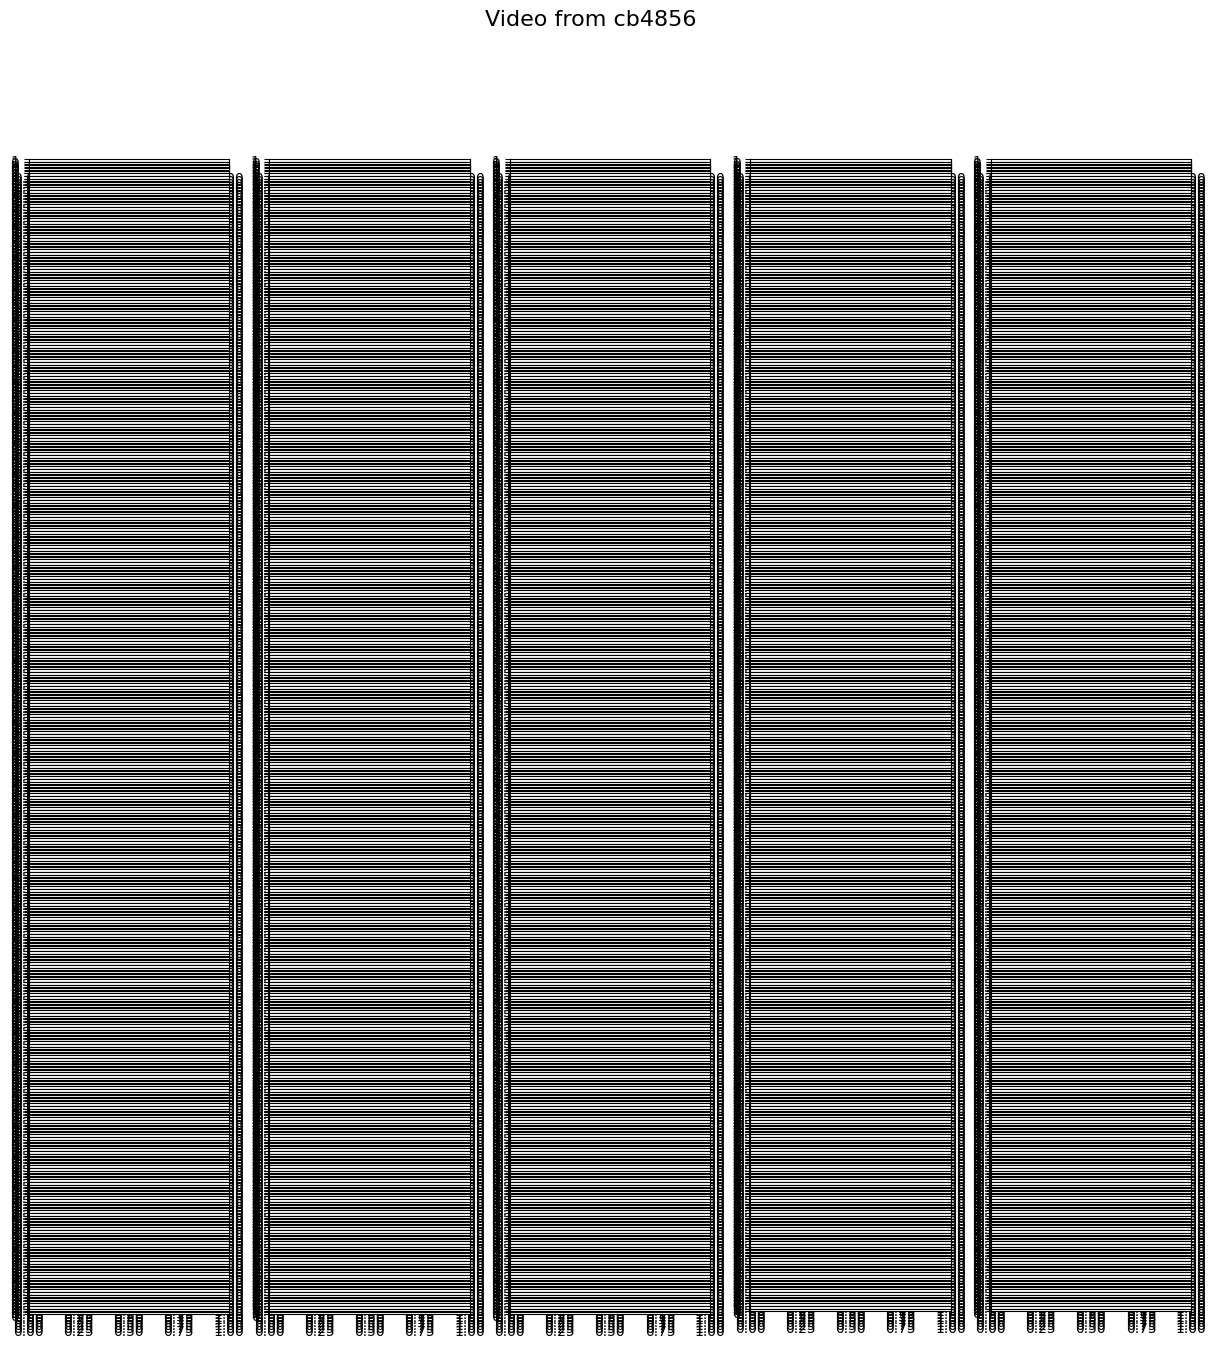

Image at index 0 is not 2D. Shape: (2048,)
Image at index 1 is not 2D. Shape: (2048,)
Image at index 2 is not 2D. Shape: (2048,)
Image at index 3 is not 2D. Shape: (2048,)
Image at index 4 is not 2D. Shape: (2048,)
Image at index 5 is not 2D. Shape: (2048,)
Image at index 6 is not 2D. Shape: (2048,)
Image at index 7 is not 2D. Shape: (2048,)
Image at index 8 is not 2D. Shape: (2048,)
Image at index 9 is not 2D. Shape: (2048,)
Image at index 10 is not 2D. Shape: (2048,)
Image at index 11 is not 2D. Shape: (2048,)
Image at index 12 is not 2D. Shape: (2048,)
Image at index 13 is not 2D. Shape: (2048,)
Image at index 14 is not 2D. Shape: (2048,)
Image at index 15 is not 2D. Shape: (2048,)
Image at index 16 is not 2D. Shape: (2048,)
Image at index 17 is not 2D. Shape: (2048,)
Image at index 18 is not 2D. Shape: (2048,)
Image at index 19 is not 2D. Shape: (2048,)
Image at index 20 is not 2D. Shape: (2048,)
Image at index 21 is not 2D. Shape: (2048,)
Image at index 22 is not 2D. Shape: (2048,

KeyboardInterrupt: 

In [14]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def extract_frames_from_hdf5(file_paths, output_directories, step=500):
    for path in file_paths:
        with h5py.File(path, 'r') as hdf:
            img_ds2 = hdf['/mask']
            print(f'Image Dataset info: Shape={img_ds2.shape}, Dtype={img_ds2.dtype}')
            for i in range(0, img_ds2.shape[0], step):
                name = "{:06d}.jpg".format(i)
                cv2.imwrite(os.path.join(output_directories[path], name), img_ds2[i, :])

def load_images_from_folder(main_folder, every_jth_image=10):
    all_images = []
    # Get all subdirectories in the main folder
    subfolders = [os.path.join(main_folder, d) for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]

    for folder in subfolders:
        imagefiles = [f for f in os.listdir(folder) if f.endswith(".jpg")]
        imagefiles.sort()

        print(f"Found {len(imagefiles)} image files in {folder}")

        for ii in range(0, len(imagefiles), every_jth_image):
            currentfilename = imagefiles[ii]
            filepath = os.path.join(folder, currentfilename)
            currentimage = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

            if currentimage is not None:
                all_images.append(currentimage)
            else:
                print(f"Failed to load image: {filepath}")

    return all_images

# Load images from subfolders
all_images = load_images_from_folder(output_root_path)
print("Total number of images loaded from all subfolders: ", len(all_images))



# Set paths
hdf5_folder_path = r'/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856'
output_root_path = os.path.join(hdf5_folder_path, 'framesExtracted')

# Ensure the output root folder exists
ensure_directory_exists(output_root_path)

# Ensure the output root folder exists
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)

# Get HDF5 file paths and create output directories
hdf5_file_paths = glob.glob(os.path.join(hdf5_folder_path, '*.hdf5'))
output_directories = create_output_directories(hdf5_file_paths, output_root_path)

# Extract frames from HDF5 files
extract_frames_from_hdf5(hdf5_file_paths, output_directories)

# Load images
all_images = load_images_from_folder(output_root_path)
print("Total number of images loaded: ", len(all_images))

# PLOT FRAMES FROM VIDEO 

# Loop through each list of images
for idx, video_images in enumerate(all_images):
    num_frames = len(video_images)
    
    # Skip if no images are loaded
    if num_frames == 0:
        print(f"No images to display for index {idx}.")
        continue

    # Calculate the number of rows and columns for the subplot
    num_cols = 5
    num_rows = int(np.ceil(num_frames / num_cols))

    # Create a new figure for each video
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axs = np.ravel(axs)

    # Get the file path corresponding to the current set of images
    file_path = hdf5_file_paths[idx]
    label_file = labels_strain_list[file_path]

    # Set the title for the figure using the label
    fig.suptitle(f"Video from {label_file}", fontsize=16)

    # Plot each frame
    for i in range(num_rows * num_cols):
        if i < num_frames:
            if video_images[i].ndim == 2:  # Check if the image is 2D
                axs[i].imshow(video_images[i], cmap='gray')
                axs[i].axis('off')
            else:
                print(f"Image at index {i} is not 2D. Shape: {video_images[i].shape}")
        else:
            axs[i].axis('off')  # Turn off extra subplots

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for title
    plt.show()


### 2. ###

Load all image files in the different folders 

This script is designed to process and organize images extracted from HDF5 files:

1. Root Directory Specification: The script starts by defining a root_directory, which is the same as output_root_path. This directory contains subdirectories, each corresponding to a specific HDF5 file.

2. List Subdirectories: It generates a list of subdirectories in the root directory. Each subdirectory represents a different HDF5 file and contains image files extracted from that HDF5 file.

3. Initialize Image Collection: An empty list all_images is initialized to store images from each HDF5 file.

4. Process Each Subdirectory: The script iterates over each subdirectory. For each subdirectory:
   
    a. It resets the imagefiles list.
    
    b. Changes the working directory to the current subdirectory.
    
    c. Collects all JPEG files in this directory, sorting them to ensure they are in the correct order.
    
    d. Image Loading and Selection: variable every_jth_image is set to 10, which determines the interval at which images will be selected. The script ensures to include the first and the last frame from each subdirectory. It then loads every 10th image (based on every_jth_image value) from the sorted list of JPEG files. These images are loaded in grayscale mode using cv2.imread. Store Processed Images: The images from each subdirectory (first frame, every 10th frame, and last frame) are appended to the all_images list.

5. Output Summary: Finally, the script prints the total number of HDF5 files processed, inferred from the length of the all_images list.

This script is particularly useful for downsampling image data from a larger set, ensuring that key frames (the first and last) are included. 

In [ ]:
# Path to the folder where all frames will be saved
output_root_path = r'/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856/framesExtracted'

# Create the output root folder if it doesn't exist
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)

# Path to the folder containing HDF5 files
hdf5_folder_path = r'/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856'

# List of file paths for HDF5 files in the folder
hdf5_file_paths = glob.glob(os.path.join(hdf5_folder_path, '*.hdf5'))
# Create a dictionary with labels for each HDF5 file
labels_strain_list = {path: extract_label_from_path(path) for path in hdf5_file_paths}

# Loop through the list of HDF5 file paths
for file_path in hdf5_file_paths:
    with h5py.File(file_path, 'r') as hdf:
        
        # Get image dataset
        img_ds2 = hdf['/mask']
        print(f'Image Dataset info: Shape={img_ds2.shape}, Dtype={img_ds2.dtype}')

        # Set the step value to control how many frames are extracted
        step = 500  # Change this value to extract frames at a different interval

        # Loop to extract frames from the current HDF5 file based on the step value
        for i in range(0, img_ds2.shape[0], step):  # Loop through frames with a step
            name = "{:06d}".format(i)
            # Save the frame directly in the common output_root_path
            cv2.imwrite(os.path.join(output_root_path, f'{name}.jpg'), img_ds2[i, :])

def load_images_from_folder(folder, every_jth_image=10):
    """
    Load every jth image directly from the specified folder.
    """
    all_images = []

    imagefiles = [file for file in os.listdir(folder) if file.endswith(".jpg")]
    imagefiles.sort()  # Sort the files to ensure they are in the correct order

    for ii in range(0, len(imagefiles), every_jth_image):
        currentfilename = imagefiles[ii]
        currentimage = cv2.imread(os.path.join(folder, currentfilename), cv2.IMREAD_GRAYSCALE)
        if currentimage is not None:
            all_images.append(currentimage)

    return all_images

# Main directory containing the images
main_folder = output_root_path

# Load images directly from the main folder
all_images = load_images_from_folder(main_folder)

print("Total number of images loaded: ", len(all_images))

We maintain the all_images list, which will contain lists of images for each HDF5 file.
Inside the loop for each subdirectory, we initialize an empty images list to store images from the current subdirectory.

After processing all images in a subdirectory, we append the images list to the all_images list. Each images list corresponds to images from one HDF5 file.

The all_images list will have one inner list for each HDF5 file, and you can access images from a specific file by indexing all_images.

At the end of this code, all_images will contain lists of images, and the length of all_images will indicate how many HDF5 files were processed.

# Test: Segmentation, cm detection in 1 frame per video #

### Segmentation


This script is designed to analyze specific frames from a collection of images, focusing on detecting and visualizing circular regions within each frame. It is a common method used in image processing. First we treshold the image, then we binarize the image so that we have black background and white blobs. This is then used for segmentation. 

1. Specify Frame to Analyze: The script starts by defining frame_chosen, an index specifying the particular frame to analyze across different image sets.

2. Initialization: Lists all_centers and all_radii are initialized to store the centers and radii of detected circular regions for each frame. An index idx is also initialized.

3. Validation: The script first checks if frame_chosen is within a valid range for the first sublist in all_images. This assumes all sublists have the same length or at least lengths greater than frame_chosen.

4. Process Each Image Set: The script iterates over each sublist in all_images:

    a. It selects the frame at index frame_chosen from the sublist.

    b. The chosen frame undergoes thresholding using Otsu's method to convert it into a binary image.

    c. It then labels connected components in the binary image.
    
    d. Region properties are extracted from the labeled image.
5. Region Filtering and Data Extraction: The script filters regions based on a threshold area size and extracts the centroid and diameter of each region:

    a. A threshold area (threshold_area) is defined.
    b. Regions smaller than this threshold are discarded.
    c. Centers and diameters of the remaining regions are calculated.

6. Radii Calculation and Storage: Radii of the detected regions are calculated and stored in all_radii, while their centers are stored in all_centers.

7. Visualization: The script plots three images side by side:

    a. The binary image (after thresholding).
    b. The labeled image (showing connected components).
    c. The original image with detected circles overlaid.
    d. The subplot titles are set, and for the third image, circles are drawn around detected regions.
    e. The script also retrieves a label for the current set of images from hdf5_file_paths using a function extract_label_from_path, which is not provided in the snippet but is assumed to extract meaningful labels from file paths.
8. Range Check: If frame_chosen is out of the valid range, a message is printed.


In [ ]:
# Specify the frame you want to analyze (0-based index)
frame_chosen = 14  # Change this to the desired frame number

# Lists to store centers and radii for each frame
all_centers = []
all_radii = []
idx = 0

# Ensure frame_chosen is within a valid range for all sublists
if frame_chosen >= 0 and frame_chosen < len(all_images[0]):
    # Loop through all sublists of images contained in all_images
    for sublist in all_images:
        if frame_chosen < len(sublist):
            # Retrieve the chosen frame from the sublist
            image = sublist[frame_chosen]

            # Perform thresholding on the current image
            threshold = threshold_otsu(image)
            binary_image = image > threshold

            # Label connected components in the binary image
            label_image = label(binary_image)

            # Color-code the labeled image
            color_label_image = color.label2rgb(label_image, image=image, bg_label=0)

            # Extract region properties from labeled image
            props = regionprops(label_image)
            centers = []
            diameters = []

            # Define the threshold area size
            threshold_area = 10  # Set the minimum area size to keep

            # Create a new list to store the filtered region properties
            filtered_props = []

            # Iterate over the region properties
            for prop in props:
                # Check the area size of the current region property
                if prop.area >= threshold_area:
                    # If the area size meets the threshold, add it to the filtered_props list
                    filtered_props.append(prop)

            # Extract centers and diameters of the detected regions
            for prop in filtered_props:
                centers.append(prop.centroid)
                diameters.append(np.mean([prop.major_axis_length, prop.minor_axis_length]))

            radii = np.array(diameters) / 2

            # Append centers and radii to the respective lists for this frame
            all_centers.append(centers)
            all_radii.append(radii)

            # Plot the images with detected circles and color-coded labeled image
            plt.figure(figsize=(18, 6))
            plt.subplot(131)
            plt.imshow(binary_image, cmap='gray')
            plt.title('Binary Image')

            plt.subplot(132)
            plt.imshow(color_label_image)
            plt.title('Connected areas color-coded')

            plt.subplot(133)
            plt.imshow(image, cmap='gray')
            for center, radius in zip(centers, radii):
                circle = plt.Circle((center[1], center[0]), radius, edgecolor='r', facecolor='none')
                plt.gca().add_patch(circle)
            # Get the file path corresponding to the current set of images
            file_path = hdf5_file_paths[idx]
            idx = idx + 1

            # Get the label for this file using a function (assuming it's defined)
            label_file = extract_label_from_path(file_path)

            # Use the label in your plot title
            plt.title(f'Image with Detected Circles - {label_file}')

            plt.show()

else:
    print("frame_chosen is out of range for the available frames in the sublists.")

# Now, all_centers and all_radii contain the data for each frame


### Number of frames and number of detected regions ###
The provided code snippet is designed to analyze the number of frames and the number of detected regions per frame in a set of images.

1. Determine Number of Frames: The code starts by finding the length of the all_radii list, which is stored in num_frames. This number represents the total number of frames across all sublists in all_images for which centers and radii of detected regions have been stored.

2. Iterate Through Videos/Images: The script iterates over all_images, which is a list of sublists, with each sublist corresponding to a different video or image set. enumerate is used to get both the index (video_i) and the sublist itself.

3. Check Frame Count: Within the loop, it first checks if num_frames is greater than zero, indicating that there are frames processed.

4. Number of Detected Regions per Frame: For each sublist (video or image set), it calculates the number of detected regions in a specific frame, which is given by the length of the sublist in all_radii at the index video_i. This value is stored in num_regions_per_frame.

5. Print Information: The script then prints the total number of frames (num_frames) and the number of detected regions per frame (num_regions_per_frame) for each video or image set.

6. Empty List Check: If num_frames is zero, indicating that all_radii is empty (no frames were processed or no regions were detected), it prints "all_centers is empty."


In [ ]:
# Check the number of frames and detected regions per frame in all_centers
num_frames = len(all_radii)
for video_i, sublist in enumerate(all_images):
    if num_frames > 0:
        num_regions_per_frame = len(all_radii[video_i])
        print("Number of Frames:", num_frames)
        print("Number of Detected Regions per Frame:", num_regions_per_frame)
    else:
        print("all_centers is empty.")

# Blob cm #


This code snippet performs image processing and analysis on all frames from each sublist of images, focusing on region properties, particularly the centroids and their distances from the center of the image. 
1. The first part of the code extracts and stores detailed region properties (normalized centers and radii from the center) for a specific frame in each HDF5 file.
    a. Initialize Lists: Two lists all_centers_norm and all_radius_from_center are initialized to store normalized center coordinates and radii from the center for each HDF5 file.
    b. Iterate Through Sublists: 
        i. For each sublist in all_images, it checks if frame_i is a valid index.
        ii. Performs thresholding on the selected frame and labels the connected components to create label_image.
        iii. Calculates the properties of each labeled region using regionprops.
        iv. Normalized Centers: The centroids of these regions are normalized by subtracting the center of the image (calculated as half of the image dimensions).
        v. Radius from Center: The Euclidean distance of each normalized centroid from the center of the image is calculated.

These normalized centers and radii are appended to all_centers_norm and all_radius_from_center, respectively.

2. The second part calculates and stores the mean of these properties for each HDF5 file.
    a. Initialize Lists for Means: Two new lists, mean_centers_norm_per_hdf5 and mean_radius_from_center_per_hdf5, are initialized to store the mean normalized centers and mean radii for each HDF5 file.

In [ ]:
# Initialize lists to store data for each HDF5 file
all_centers_norm_per_hdf5 = []
all_radius_from_center_per_hdf5 = []

# Initialize lists to store mean and standard deviation data for each HDF5 file
mean_centers_norm_per_hdf5 = []
std_radius_from_center_per_hdf5 = []

# Iterate through each sublist corresponding to an HDF5 file
for sublist in all_images:
    # Initialize lists to store data for each frame in the current HDF5 file
    all_centers_norm = []
    all_radius_from_center = []

    # Iterate through each frame in the sublist
    for frame in sublist:
        # Label the image for the current frame
        label_image = label(frame > threshold_otsu(frame))

        # Calculate the region properties
        stats = regionprops(label_image)

        # Calculate the normalized centers
        centers_norm = np.array([prop.centroid for prop in stats]) - np.round(np.array(frame.shape) / 2)

        # Calculate the radius from the center
        radius_from_center = np.sqrt(np.sum(centers_norm ** 2, axis=1))

        # Append centers_norm and radius_from_center to the respective lists
        all_centers_norm.append(centers_norm)
        all_radius_from_center.append(radius_from_center)

    # Store data for all frames of the current HDF5 file
    all_centers_norm_per_hdf5.append(all_centers_norm)
    all_radius_from_center_per_hdf5.append(all_radius_from_center)

    # Calculate and store mean and standard deviation data for the current HDF5 file
    mean_centers_norm = np.mean(np.vstack(all_centers_norm), axis=0)
    std_radius_from_center = np.std(np.hstack(all_radius_from_center))

    mean_centers_norm_per_hdf5.append(mean_centers_norm)
    std_radius_from_center_per_hdf5.append(std_radius_from_center)

# Now, all_centers_norm_per_hdf5 and all_radius_from_center_per_hdf5 contain lists of data for each frame in each HDF5 file.
# mean_centers_norm_per_hdf5 contains the means of centers_norm per HDF5 file.
# std_radius_from_center_per_hdf5 contains the standard deviations of radius_from_center per HDF5 file.


### Violin plot of blob cm to center image distance ###

In [ ]:
# Number of datasets
n_datasets = len(all_radius_from_center_per_hdf5)

# Create a new figure for the violin plot
plt.figure(figsize=(15, 8))

# Flatten the data for violin plot
# Each sublist in 'all_radius_from_center_per_hdf5' contains lists for each frame; we concatenate them into a single list per HDF5 file
violin_data = [np.concatenate(radius_list) for radius_list in all_radius_from_center_per_hdf5]

# Extract labels for each dataset from hdf5_file_paths or another source
# This assumes a function 'extract_label_from_path' that extracts a meaningful label from the file path
labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]

# Create violin plot using seaborn
sns.violinplot(data=violin_data, inner="quartile", scale="count")

# Add individual data points as a swarmplot
sns.swarmplot(data=violin_data, color="k", alpha=0.5)

# Customize the plot
plt.title('Blob Radius Distances from Image Center')
plt.xlabel('Datasets')
plt.ylabel('Distance from Image Center')
plt.xticks(ticks=range(len(labels)), labels=labels)  # Set x-axis labels to actual dataset names

# Show the plot
plt.show()


### Time series plot ###

In [ ]:
# Extract labels for each dataset
labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]

# Create a single figure for all time series
plt.figure(figsize=(15, 8))

# Plotting radius from center with standard deviation as a shadowed area for each dataset
for idx, (dataset, std_dev) in enumerate(zip(all_radius_from_center_per_hdf5, std_radius_from_center_per_hdf5)):
    radius_data = np.array([np.mean(frame) if len(frame) > 0 else np.nan for frame in dataset])
    std_dev_data = np.array([np.std(frame) if len(frame) > 0 else np.nan for frame in dataset])

    frame_numbers = np.arange(len(radius_data))

    # Plotting the mean data
    dataset_label = labels[idx] if idx < len(labels) else f"Dataset {idx + 1}"
    plt.plot(frame_numbers, radius_data, label=dataset_label)

    # Adding the standard deviation shadow
    plt.fill_between(frame_numbers, radius_data - std_dev_data, radius_data + std_dev_data, alpha=0.2)

plt.title('Radius from Center Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Mean Radius from Center')
plt.legend()
plt.show()


### Quantification of blobs spread 

In [ ]:
def calculate_stats(x_coords, y_coords):
    mean_x = np.mean(x_coords)
    mean_y = np.mean(y_coords)
    std_x = np.std(x_coords)
    std_y = np.std(y_coords)
    cov_matrix = np.cov(x_coords, y_coords)
    return mean_x, mean_y, std_x, std_y, cov_matrix

def plot_density(ax, mean_x, mean_y, cov_matrix, x_coords, y_coords, x_range, y_range):
    x, y = np.mgrid[x_range[0]:x_range[1]:.1, y_range[0]:y_range[1]:.1]
    pos = np.dstack((x, y))
    rv = multivariate_normal([mean_x, mean_y], cov_matrix)
    z = rv.pdf(pos)
    ax.contourf(x, y, z, cmap="Blues")
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
#     ax.set_title("Density Estimation (KDE)")
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")

def plot_scatter(x_coords, y_coords):
    plt.scatter(x_coords, y_coords, c='red', label='Blob Centers')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.title('Scatter Plot of Blob Centers')
    plt.legend()
    plt.show()

## This is for one frame ##

### Density plot of cm distribution in frame "frame_chosen" ###

This is mostly for visualization on one frame. The analysis is used on all frames though. 

This code snippet visualizes the spatial distribution of the blobs center of mass using Kernel Density Estimation (KDE). 

1. Frame Selection: The script sets frame_chosen to 14, indicating that it's interested in analyzing data corresponding to the 14th frame in each dataset.

2. Global Coordinate Extents: It calculates the global minimum and maximum x and y coordinates across all datasets to ensure consistent plotting scales.

3. Subplot Arrangement: The number of rows and columns for the subplots is determined based on the square root of the total number of datasets (n_datasets).

4. Creating Subplots: A figure with a grid of subplots is created.

5. Data Analysis and Plotting:

    a. It loops through each dataset.
    b. For each dataset, it checks if frame_chosen is within the valid range of frames.
    c. Extracts the centers (coordinates) for the chosen frame from the current dataset.
    d. Skips datasets with insufficient data.
    e. Calculates statistical measures (mean, standard deviation, covariance matrix).
    f. Performs a Kernel Density Estimation (KDE) based on these statistics and plots the density on the corresponding subplot.
    g. Cleaning Up: The script removes any unused subplots.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

# Assuming calculate_stats and plot_density are defined functions

# Frame chosen for analysis
frame_chosen = 14

# Assuming all_centers is derived from all_centers_norm_per_hdf5 for the chosen frame
all_centers = [dataset[frame_chosen] for dataset in all_centers_norm_per_hdf5 if frame_chosen < len(dataset)]

# Determine global min and max for x and y coordinates
global_min_x = min([min(centers[:,0]) for centers in all_centers if len(centers) > 0])
global_max_x = max([max(centers[:,0]) for centers in all_centers if len(centers) > 0])
global_min_y = min([min(centers[:,1]) for centers in all_centers if len(centers) > 0])
global_max_y = max([max(centers[:,1]) for centers in all_centers if len(centers) > 0])

# Number of datasets
n_datasets = len(all_centers)

# Number of rows and columns for subplots
n_rows = int(np.ceil(np.sqrt(n_datasets)))
n_cols = n_rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array to 1D for easier indexing

# Extract labels for each dataset
dataset_labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]

for dataset_index, centers in enumerate(all_centers):
    # Check for empty lists
    if len(centers) == 0:
        print(f"Skipping {dataset_labels[dataset_index]}, Frame {frame_chosen} due to lack of data.")
        continue
    
    # Calculate statistics
    mean_x, mean_y, std_x, std_y, cov_matrix = calculate_stats(centers[:,0], centers[:,1])

    # Try to compute KDE
    try:
        rv = multivariate_normal([mean_x, mean_y], cov_matrix)
    except np.linalg.LinAlgError:
        print(f"Could not compute KDE for {dataset_labels[dataset_index]}, Frame {frame_chosen}.")
        continue
            
    # Plot KDE on the corresponding subplot
    plot_density(axes[dataset_index], mean_x, mean_y, cov_matrix, centers[:,0], centers[:,1], (global_min_x, global_max_x), (global_min_y, global_max_y))
    
    # Add a title with the dataset name and frame number
    axes[dataset_index].set_title(f'{dataset_labels[dataset_index]}, Frame {frame_chosen}')

    # Remove y-axis label except for the first plot
    if dataset_index != 0:
        axes[dataset_index].set_ylabel('')

# Remove any unused subplots
for i in range(dataset_index + 1, n_rows * n_cols):
    if i < len(axes):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Distance between center of mass blobs ##

This code snippet is designed to visualize the distribution of pairwise distances between blobs center of mass within multiple datasets. It uses violin plots to display this information.

1. Data Preparation

    a. Initialize a List for Distances: all_distances is initialized to store the pairwise distances for each dataset.

    b. Loop Through Datasets: The code iterates over a certain number of datasets (n_datasets), which is determined by the length of all_centers.

2. Process Each Dataset:

    a. For each dataset, it retrieves a list of centers (centers).

    b. It checks if the list of centers is empty. If so, it skips the dataset and appends an empty list to all_distances.
    
    c. If the list is not empty, it calculates the pairwise distances between all centers using Euclidean distance. This is done using pdist from the SciPy library.

    d. These distances are then appended to all_distances.

3. Visualization with Violin and Swarm Plots

    a. Prepare for Violin Plot:

        i. A new figure is created with a specified size.

        ii. violin_data is set to all_distances, which now contains lists of pairwise distances for each dataset.

        iii. Labels for each dataset are generated in the format Dataset_{i+1}.
    
    b. Create Violin Plot:

        i. A violin plot is created using Seaborn's violinplot. This plot will visualize the distribution of pairwise distances within each dataset.
        
        ii. The inner="quartile" parameter in the violin plot indicates that the quartiles will be shown inside the violins.
        scale="count" scales the width of the violins based on the number of observations in each dataset.

    c. Swarm Plot Overlay:

        i. A swarm plot is overlaid on the violin plot with sns.swarmplot. This adds individual data points to the visualization, enhancing the interpretability of the distribution.

        ii. Customization and Display:

        iii. The plot is titled 'Violin Plots for Pairwise Distances Between Blobs'.
        iv. Axes are labeled appropriately, and x-axis ticks are set to the generated dataset labels.
        v. The plot is displayed using plt.show().

In [ ]:
# # Initialize an empty list to store distances for all datasets
# all_distances = []

# # Extract dataset labels
# dataset_labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]  # Replace with actual paths

# for dataset_index, centers in enumerate(all_centers_norm_per_hdf5):
#     # Check for empty lists
#     if len(centers) == 0:
#         print(f"Skipping {dataset_labels[dataset_index]} due to lack of data.")
#         all_distances.append([])  # Append an empty list for this dataset
#         continue

#     # Flatten the centers data for each frame and calculate pairwise distances
#     flattened_centers = np.vstack(centers)
#     distances = pdist(flattened_centers, 'euclidean')
    
#     # Append the distances to the all_distances list
#     all_distances.append(distances)

# # Create a new figure for the violin plot
# plt.figure(figsize=(15, 8))

# # Prepare data for violin plot
# violin_data = all_distances  # Each sublist in 'all_distances' will become a violin in the violin plot

# # Create violin plot using seaborn
# sns.violinplot(data=violin_data, inner="quartile", scale="count")

# # Add individual data points as a swarmplot
# sns.swarmplot(data=violin_data, color="k", alpha=0.5)

# # Customize the plot
# plt.title('Pairwise Distances Between Blobs')
# plt.xlabel('Datasets')
# plt.ylabel('Pairwise Distance')
# plt.xticks(ticks=range(len(dataset_labels)), labels=dataset_labels)  # Set x-axis labels to actual dataset names

# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist

# Assuming all_centers_norm_per_hdf5 and hdf5_file_paths are defined

# Initialize an empty list to store distances for a subset of datasets
all_distances = []

# Extract dataset labels
dataset_labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]

# Limit the number of datasets to process for testing
num_datasets_to_test = 5  # Adjust this number as needed

for dataset_index, centers in enumerate(all_centers_norm_per_hdf5[:num_datasets_to_test]):
    if len(centers) == 0:
        print(f"Skipping {dataset_labels[dataset_index]} due to lack of data.")
        continue

    flattened_centers = np.vstack(centers)
    distances = pdist(flattened_centers, 'euclidean')
    all_distances.append(distances)

# Create violin plot for the subset
plt.figure(figsize=(15, 8))
sns.violinplot(data=all_distances, inner="quartile", scale="count")
sns.swarmplot(data=all_distances, color="k", alpha=0.5)
plt.title('Pairwise Distances Between Blobs (Subset)')
plt.xlabel('Datasets')
plt.ylabel('Pairwise Distance')
plt.xticks(ticks=range(len(dataset_labels[:num_datasets_to_test])), labels=dataset_labels[:num_datasets_to_test])
plt.show()


# Size blob  #
Estimation of Major and Mionor axis 

### This is for one frame ###

In [ ]:
# Initialize a list to store areas for each sublist
areas = []

# Specify the frame index you want to analyze for each HDF5 file
frame_i = 3  # Change this to the frame index you want to analyze

# Extract labels for each dataset
dataset_labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]

# Iterate through each sublist corresponding to an HDF5 file
for sublist in all_images:
    sublist_areas = []  # Initialize a sublist-specific area list
    
    if frame_i < len(sublist):
        # Assuming you have the labeled image 'label_image' for the chosen frame
        label_image = label(sublist[frame_i] > threshold_otsu(sublist[frame_i]))

        # Calculate the region properties
        stats = regionprops(label_image)

        # Calculate the areas for each blob and append to the sublist-specific area list
        sublist_areas.extend(np.pi * np.array([prop.major_axis_length * prop.minor_axis_length / 4 for prop in stats]))
    
    # Append the sublist-specific area list to the main 'areas' list
    areas.append(sublist_areas)

# Create a new figure for the violin plot
plt.figure(figsize=(15, 8))

# Prepare data for violin plot
violin_data = areas  # Each sublist in 'areas' will become a violin in the violin plot

# Create violin plot using seaborn
sns.violinplot(data=violin_data, inner="quartile", scale="count")

# Add individual data points as a swarmplot
sns.swarmplot(data=violin_data, color="k", alpha=0.5)

# Customize the plot
plt.title('Violin Plots for Blob Areas')
plt.xlabel('Datasets')
plt.ylabel('Blob Area (pixels^2/9)')
plt.xticks(ticks=range(len(dataset_labels)), labels=dataset_labels)  # Set x-axis labels to actual dataset names

# Show the plot
plt.show()

## On all frames ##

In [ ]:
# Initialize a list to store areas for each sublist
areas = []

# Extract labels for each dataset
dataset_labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]

# Iterate through each sublist corresponding to an HDF5 file
for sublist in all_images:
    sublist_areas = []  # Initialize a sublist-specific area list

    # Iterate through each frame in the sublist
    for frame in sublist:
        # Label the image for the current frame
        label_image = label(frame > threshold_otsu(frame))

        # Calculate the region properties
        stats = regionprops(label_image)

        # Calculate the areas for each blob and append to the sublist-specific area list
        sublist_areas.extend(np.pi * np.array([prop.major_axis_length * prop.minor_axis_length / 4 for prop in stats]))
    
    # Append the sublist-specific area list to the main 'areas' list
    areas.append(sublist_areas)

# Create a new figure for the violin plot
plt.figure(figsize=(15, 8))

# Prepare data for violin plot
violin_data = areas  # Each sublist in 'areas' will become a violin in the violin plot

# Create violin plot using seaborn
sns.violinplot(data=violin_data, inner="quartile", scale="count")

# Add individual data points as a swarmplot
sns.swarmplot(data=violin_data, color="k", alpha=0.5)

# Customize the plot
plt.title('Violin Plots for Blob Areas Across All Frames')
plt.xlabel('Datasets')
plt.ylabel('Blob Area (pixels^2)')
plt.xticks(ticks=range(len(dataset_labels)), labels=dataset_labels)  # Set x-axis labels to actual dataset names

plt.show()

### Time series plot ###

In [ ]:
# Initialize lists to store mean and standard deviation of areas for each frame in each sublist
mean_areas_per_frame = []
std_areas_per_frame = []

# Extract labels for each dataset
dataset_labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]

# Iterate through each sublist corresponding to an HDF5 file
for sublist in all_images:
    frame_areas = []  # Store areas for each frame in the sublist

    # Iterate through each frame in the sublist
    for frame in sublist:
        # Label the image for the current frame
        label_image = label(frame > threshold_otsu(frame))

        # Calculate the region properties
        stats = regionprops(label_image)

        # Calculate the areas for each blob
        areas = [np.pi * prop.major_axis_length * prop.minor_axis_length / 4 for prop in stats] if stats else [0]

        # Append the areas for this frame to frame_areas
        frame_areas.append(areas)

    # Calculate and append mean and standard deviation of areas per frame
    mean_areas = [np.mean(areas) for areas in frame_areas]
    std_areas = [np.std(areas) for areas in frame_areas]
    mean_areas_per_frame.append(mean_areas)
    std_areas_per_frame.append(std_areas)

# Create a new figure for the time series plot
plt.figure(figsize=(15, 8))

# Plotting time series with standard deviation for each dataset
for idx, (mean_areas, std_areas) in enumerate(zip(mean_areas_per_frame, std_areas_per_frame)):
    frames = np.arange(len(mean_areas))
    plt.plot(frames, mean_areas, label=dataset_labels[idx] if idx < len(dataset_labels) else f"Dataset {idx + 1}")
    plt.fill_between(frames, np.array(mean_areas) - np.array(std_areas), np.array(mean_areas) + np.array(std_areas), alpha=0.3)

plt.title('Blob Areas')
plt.xlabel('Frame Number')
plt.ylabel('Mean Blob Area (pixels^2)')
plt.legend()
plt.show()

# Geometric characterization 

# Hu Moments #

In [ ]:
def eta_generate(i, j, image):
    _lambda = (i + j) / 2 + 1
    mu_ij = mu_generate(i, j, image)
    mu_00 = np.sum(image)
    eta_ij = mu_ij / mu_00  # ** _lambda
    return eta_ij

In [ ]:
def mu_generate(i, j, image):
    M = image.shape[0]
    N = image.shape[1]
    m_00 = np.sum(image)
    x = np.arange(1, M+1)
    y = np.arange(1, N+1)
    m_10 = np.sum(x * image)
    m_01 = np.sum(y * image)

    x_prime = m_10 / m_00
    y_prime = m_01 / m_00

    x_component = (x - x_prime) ** i
    y_component = (y - y_prime) ** j

    product_xy_component = np.outer(x_component, y_component)
    product_xy_component_image = product_xy_component * image

    mu_ij = np.sum(product_xy_component_image)
    return mu_ij

In [ ]:
def im2double(image):
    return image.astype(np.float64) / np.max(image)
    # normalizes the image 

Compute Hu moments for one frame for each video and plot them together 

In [ ]:

# Initialize the number of videos (HDF5 files)
num_videos = len(all_images)

# Initialize an empty array to store the Hu moments for all videos
phi_1 = np.zeros((num_videos, 7))

# Choose a specific frame for analysis (e.g., frame 3)
frame_i = 3

# Loop through each video (HDF5 file)
for video_i, sublist in enumerate(all_images):
    if frame_i < len(sublist):
        # Assuming you have the labeled image 'label_image' for the chosen frame
        im = sublist[frame_i]

        eta_02 = eta_generate(0, 2, im)
        eta_03 = eta_generate(0, 3, im)
        eta_11 = eta_generate(1, 1, im)
        eta_12 = eta_generate(1, 2, im)
        eta_20 = eta_generate(2, 0, im)
        eta_21 = eta_generate(2, 1, im)
        eta_30 = eta_generate(3, 0, im)

        phi_1[video_i, 0] = eta_20 + eta_02
        phi_1[video_i, 1] = (eta_20 + eta_02) ** 2 + 4 * eta_11 ** 2
        phi_1[video_i, 2] = (eta_30 - 3 * eta_12) ** 2 + (3 * eta_21 - eta_03) ** 2
        phi_1[video_i, 3] = (eta_30 + eta_12) ** 2 + (eta_21 + eta_03) ** 2
        phi_1[video_i, 4] = (3 * eta_21 - eta_03) * (eta_21 + eta_03) * (
                    (eta_30 + eta_12) ** 2 - (eta_21 + eta_03) ** 2) + (
                                       eta_30 - 3 * eta_12) * (eta_30 + eta_12) * (
                                               (eta_30 + eta_12) ** 2 - 3 * (eta_21 + eta_03) ** 2)
        phi_1[video_i, 5] = (3 * eta_21 - eta_03) * ((eta_30 + eta_12) ** 2 - (eta_21 + eta_03) ** 2) + 4 * eta_11 * (
                    eta_30 + eta_12) * (eta_21 + eta_03)
        phi_1[video_i, 6] = (3 * eta_21 - eta_03) * (eta_30 + eta_12) * (
                    (eta_30 + eta_12) ** 2 - 3 * (eta_21 + eta_03) ** 2) - (
                                       eta_30 - 3 * eta_12) * (eta_21 + eta_03) * (
                                               3 * (eta_30 + eta_12) ** 2 - (eta_21 + eta_03) ** 2)

# Plot the Hu moments for all videos
plt.figure()
for video_i in range(num_videos):
    file_path = hdf5_file_paths[video_i]
    # Get the label for this file using the function
    label_file = extract_label_from_path(file_path)
    plt.plot(phi_1[video_i], '.-', label=f'{label_file}')
plt.title('Hu Moments for frame i', fontsize=14)
plt.xlabel('Hu Moment #', fontsize=12)
plt.ylabel(r'$\phi$', fontsize=16)
plt.axis('tight')

# Place the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [ ]:

# Initialize the number of videos (HDF5 files)
num_videos = len(all_images)

# Initialize the number of frames per video (assuming all videos have the same number of frames)
num_frames_per_video = len(all_images[0])

# Initialize arrays to store Hu moments and distances for all videos and frames
phi = np.zeros((num_videos, num_frames_per_video, 7))
dist = np.zeros((num_videos, num_frames_per_video, 1))

# Loop through each video
for video_i, video_frames in enumerate(all_images):
    for frame_i, im in enumerate(video_frames):
        eta_02 = eta_generate(0, 2, im)
        eta_03 = eta_generate(0, 3, im)
        eta_11 = eta_generate(1, 1, im)
        eta_12 = eta_generate(1, 2, im)
        eta_20 = eta_generate(2, 0, im)
        eta_21 = eta_generate(2, 1, im)
        eta_30 = eta_generate(3, 0, im)

        phi[video_i, frame_i, 0] = eta_20 + eta_02
        phi[video_i, frame_i, 1] = (eta_20 + eta_02) ** 2 + 4 * eta_11 ** 2
        phi[video_i, frame_i, 2] = (eta_30 - 3 * eta_12) ** 2 + (3 * eta_21 - eta_03) ** 2
        phi[video_i, frame_i, 3] = (eta_30 + eta_12) ** 2 + (eta_21 + eta_03) ** 2
        phi[video_i, frame_i, 4] = (3 * eta_21 - eta_03) * (eta_21 + eta_03) * (
                (eta_30 + eta_12) ** 2 - (eta_21 + eta_03) ** 2) + (
                                           eta_30 - 3 * eta_12) * (eta_30 + eta_12) * (
                                                   (eta_30 + eta_12) ** 2 - 3 * (eta_21 + eta_03) ** 2)
        phi[video_i, frame_i, 5] = (3 * eta_21 - eta_03) * ((eta_30 + eta_12) ** 2 - (eta_21 + eta_03) ** 2) + 4 * eta_11 * (
                eta_30 + eta_12) * (eta_21 + eta_03)
        phi[video_i, frame_i, 6] = (3 * eta_21 - eta_03) * (eta_30 + eta_12) * (
                (eta_30 + eta_12) ** 2 - 3 * (eta_21 + eta_03) ** 2) - (
                                           eta_30 - 3 * eta_12) * (eta_21 + eta_03) * (
                                                   3 * (eta_30 + eta_12) ** 2 - (eta_21 + eta_03) ** 2)

        dist[video_i, frame_i, 0] = np.sqrt(np.sum(phi[video_i, frame_i, :] ** 2))


# Plot Hu moments for all videos in time
plt.figure(figsize=(12, 6))
for video_i in range(num_videos):
    for moment_i in range(7):
        file_path = hdf5_file_paths[video_i]
        # Get the label for this file using the function
        label_file = extract_label_from_path(file_path)
        plt.plot(phi[video_i, :, moment_i], '.-', label=f'{label_file}, Hu Moment {moment_i + 1}')
plt.title('Hu Moments Over Time', fontsize=14)
plt.xlabel('Frame Index', fontsize=12)
plt.ylabel(r'$\phi$', fontsize=16)
plt.axis('tight')
# Position the legend outside of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.show()

# Plot distance for all videos in time
plt.figure(figsize=(12, 6))
for video_i in range(num_videos):
    file_path = hdf5_file_paths[video_i]
    # Get the label for this file using the function
    label_file = extract_label_from_path(file_path)
    plt.plot(dist[video_i, :, 0], '.-', label=f'{label_file}')
plt.title('Distance Over Time', fontsize=14)
plt.xlabel('Frame Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axis('tight')
# Position the legend outside of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.show()

What $\textbf{dist}$ represents: 

In simpler terms, the dist value gives a measure of the "magnitude" or "size" of the Hu moments for each frame (7 dimensions in this case since there are seven Hu moments). This can be thought of as a single value summary of the shape described by the Hu moments. In the context of the code, this could be used to quickly compare or assess the shapes in each frame across videos. If two frames have similar dist values, their shapes (as described by the Hu moments) could be considered to be of similar complexity or magnitude.

Perform Hierarchical clustering on the images based on the distance estimated through the Hu moments 

Plot the normalized Hu moments in time. 

Normalization is useful because the value range of the different coefficient varies much. 

In [ ]:

# Reshape phi to combine the video and frame dimensions
phi_reshaped = phi.reshape(-1, phi.shape[-1])

# Compute the zscore for the reshaped phi
phi_normalized_reshaped = zscore(phi_reshaped, axis=0)

# Reshape it back to the original 3D structure
phi_normalized = phi_normalized_reshaped.reshape(phi.shape)


# Plot normalized Hu moments for each video
plt.figure(figsize=(12, 6))
for video_i in range(phi_normalized.shape[0]):
    file_path = hdf5_file_paths[video_i]
    # Get the label for this file using the function
    label_file = extract_label_from_path(file_path)
    for moment_i in range(7):
        plt.plot(phi_normalized[video_i, :, moment_i], '.-', label=f'{label_file}, Hu Moment {moment_i + 1}')
plt.title('Normalized Hu Moments Over Time', fontsize=14)
plt.ylabel(r'$\phi$', fontsize=16)
plt.xlabel('t (frames)', fontsize=12)
plt.axis('tight')

# Place the legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjusts the plot so that everything fits neatly
plt.show()


# Assuming you want to compute pairwise distances between frames for a specific video
video_index = 0  # e.g., for the first video
distance_vector = pdist(phi_normalized[video_index], 'minkowski')
distance_matrix = squareform(distance_vector)


# Zernike Moments #

Come back to this later

In [ ]:
def zernike_moments(image, radius, degree):
    # Compute the Zernike moments for a given image, radius, and degree
    
    # Create a grid of points within the image
    rows, cols = image.shape
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    points = np.stack((x, y), axis=2)
    
    # Compute the centroid of the image
    centroid = measure.regionprops(image.astype(int))[0].centroid
    
    # Compute the distance of each point from the centroid
    distances = np.sqrt((points[:, :, 0] - centroid[1])**2 + (points[:, :, 1] - centroid[0])**2)
    
    # Create a binary mask for points within the specified radius
    mask = distances <= radius
    
    # Compute the Zernike moments using the binary mask
    moments = np.zeros(degree + 1, dtype=np.complex128)
    
    for n in range(degree + 1):
        for m in range(-n, n + 1, 2):
            re = np.sum(image * draw.disk(centroid[::-1], radius, shape=image.shape) * np.real(zernike(n, m, distances/radius) * mask))
            im = np.sum(image * draw.disk(centroid[::-1], radius, shape=image.shape) * np.imag(zernike(n, m, distances/radius) * mask))
            moments[n] += re + 1j * im
    
    return moments

def zernike(n, m, r):
    # Compute the Zernike polynomials for a given degree and order
    
    if m > 0:
        return np.sqrt((2 * (n + 1)) / np.pi) * np.polynomial.chebyshev.chebval(r, np.polynomial.zernike.zernike_poly(n, m))
    elif m == 0:
        return np.sqrt(n + 1) * np.pi / 2
    else:
        return np.sqrt((2 * (n + 1)) / np.pi) * np.polynomial.chebyshev.chebval(r, np.polynomial.zernike.zernike_poly(n, -m)) * 1j


In [ ]:
# zernike_moments(images[image_i], 3, 2)

# Wavelet Transform #

### Wavelet Transform implementation ###

This code performs wavelet transform analysis on video frames and then visualizes and compares the frames using the results of the transform. 

1. Wavelet Transform Function (apply_wavelet_transform):

    a. This function applies a discrete wavelet transform to an image using the Haar wavelet.
    b. It returns the coefficients of the transform, which include the approximation coefficients (cA) and the detailed coefficients in horizontal (cH), vertical (cV), and diagonal (cD) orientations.

2. Plotting Wavelet Coefficients (plot_wavelet_coeffs):

    a. This function visualizes the wavelet coefficients of a frame.
    b. It plots the approximation and detailed coefficients in separate subplots.
    c. The coefficients are displayed in grayscale, and each subplot is titled according to the type of coefficient it represents (approximation, horizontal, vertical, diagonal).

3. Processing and Visualizing Each Video Frame:

    a. The code iterates through a list of videos (all_images). For each video, it selects a specific frame (defined by frame_index).
I   b. It applies the wavelet transform to this frame and plots the resulting coefficients using the plot_wavelet_coeffs function.

4. Storing Wavelet Coefficients:

    a. For each video, the wavelet coefficients of the specified frame are computed and stored in a list (all_coeffs).

5. Computing Similarity Matrix:

    a. A similarity matrix is constructed to compare frames across videos.
    b.  The Euclidean distance between the flattened approximation coefficients (cA) of each pair of frames is calculated. This distance serves as a measure of similarity between frames.
    c. The computed distances are stored in the similarity matrix.

6. Visualizing the Similarity Matrix:

    a. A heatmap is created using Seaborn to visualize the similarity matrix.
    b. The heatmap displays the Euclidean distances between the approximation coefficients of the frames, providing a visual representation of frame similarity across different videos.
    c. The axes of the heatmap are labeled with the video numbers.

### Compute wavelet transform on all frames 

In [ ]:

def apply_wavelet_transform(image):
    # Apply wavelet transform to the image and return coefficients
    coeffs = pywt.dwt2(image, 'haar')
    return coeffs

# Assuming 'all_videos' is a list of videos, where each video is a list of frames
num_videos = len(all_images)

# Dictionaries to store coefficients for each video
cA_dict = {}
cH_dict = {}
cV_dict = {}
cD_dict = {}

for vid_index, video_frames in enumerate(all_images):
    # Lists to store coefficients for each frame in the current video
    cA_list = []
    cH_list = []
    cV_list = []
    cD_list = []

    for frame in video_frames:
        # Apply wavelet transform
        coeffs = apply_wavelet_transform(frame)

        # Get the approximation and details coefficients
        cA, (cH, cV, cD) = coeffs

        # Append the coefficients for each frame to the respective lists
        cA_list.append(cA)
        cH_list.append(cH)
        cV_list.append(cV)
        cD_list.append(cD)
    
    # Convert the lists to numpy arrays for further processing if needed and store in the dictionaries
    cA_dict[vid_index] = np.array(cA_list)
    cH_dict[vid_index] = np.array(cH_list)
    cV_dict[vid_index] = np.array(cV_list)
    cD_dict[vid_index] = np.array(cD_list)


### Don't run this on the divergent data set 

In [ ]:
def apply_wavelet_transform(image):
    # Apply wavelet transform to the image and return coefficients
    coeffs = pywt.dwt2(image, 'haar')
    return coeffs

# Assuming 'all_videos' is a list of videos, where each video is a list of frames
num_videos = len(all_images)

# Extract dataset labels
dataset_labels = [extract_label_from_path(file_path) for file_path in hdf5_file_paths]

# Dictionaries to store coefficients for each video
cA_dict = {}
cH_dict = {}
cV_dict = {}
cD_dict = {}

for vid_index, video_frames in enumerate(all_images):
    # Lists to store coefficients for each frame in the current video
    cA_list, cH_list, cV_list, cD_list = [], [], [], []

    for frame in video_frames:
        coeffs = apply_wavelet_transform(frame)
        cA, (cH, cV, cD) = coeffs
        cA_list.append(cA)
        cH_list.append(cH)
        cV_list.append(cV)
        cD_list.append(cD)
    
    cA_dict[vid_index] = np.array(cA_list)
    cH_dict[vid_index] = np.array(cH_list)
    cV_dict[vid_index] = np.array(cV_list)
    cD_dict[vid_index] = np.array(cD_list)

# Variable to control plot display
display_plots = True

if display_plots:
    num_frames = cA_dict[0].shape[0]  # Assuming each video has the same number of frames
    fig, axes = plt.subplots(num_frames * num_videos, 4, figsize=(12, 4*num_frames*num_videos))

    for vid_index in range(num_videos):
        for k in range(num_frames):
            row_idx = vid_index * num_frames + k
            dataset_label = dataset_labels[vid_index]  # Use the dataset label

            axes[row_idx, 0].imshow(cA_dict[vid_index][k], cmap='viridis', aspect='auto', origin='upper')
            axes[row_idx, 0].set_title(f'{dataset_label} - Approximation')
            
            axes[row_idx, 1].imshow(cH_dict[vid_index][k], cmap='viridis', aspect='auto', origin='upper')
            axes[row_idx, 1].set_title(f'{dataset_label} - Horizontal Detail')
            
            axes[row_idx, 2].imshow(cV_dict[vid_index][k], cmap='viridis', aspect='auto', origin='upper')
            axes[row_idx, 2].set_title(f'{dataset_label} - Vertical Detail')
            
            axes[row_idx, 3].imshow(cD_dict[vid_index][k], cmap='viridis', aspect='auto', origin='upper')
            axes[row_idx, 3].set_title(f'{dataset_label} - Diagonal Detail')

    for ax in axes[0, :]:
        ax.set_xlabel('X-Axis')
    for ax in axes[:, 0]:
        ax.set_ylabel('Frame Index')

    plt.tight_layout()
    plt.show()


## Distance matrix ##

The provided code performs the computation of distance matrices for a set of videos based on wavelet transform coefficients. xtracts wavelet coefficients from video frames, flattens and combines them into a feature matrix, and computes a distance matrix representing the pairwise Euclidean distances between frames based on these features.

1. Setup and Initialization:

    a. video_keys: This retrieves keys from the cA_dict, which likely represent different videos.
    b. distance_matrices: A dictionary initialized to store the distance matrices for each video.

2. Iterating Through Videos:

    The code iterates over each video, identified by vid_key in video_keys.

3. Retrieving and Reshaping Wavelet Coefficients:

    a. For each video, it retrieves the wavelet coefficients stored in cA_dict, cH_dict, cV_dict, and cD_dict. These coefficients are likely the approximation, horizontal detail, vertical detail, and diagonal detail coefficients, respectively.
    
    b. num_frames: The number of frames in each video is determined.
    
    c. The coefficients for each type are reshaped into 2D arrays where each row represents a frame, and the columns represent the flattened coefficients.

4. Creating Feature Matrices:

    a. The reshaped (flattened) coefficients are combined into a single feature matrix for each video. This matrix concatenates the approximation, horizontal, vertical, and diagonal coefficients side-by-side.

5. Computing Distance Matrices:

    a. A distance matrix is calculated using the Euclidean distance metric for each video. This matrix measures the pairwise distances between the feature representations of each frame.
    
    b. The cdist function from SciPy (assuming imported) is used to calculate the pairwise Euclidean distances between the rows (frames) of the feature matrix.

6. Storing Distance Matrices:

    a. The computed distance matrix for each video is stored in the distance_matrices dictionary with the vid_key as the key.

In [ ]:
video_keys = cA_dict.keys()

distance_matrices = {}  # Dictionary to store distance matrices for each video

for vid_key in video_keys:
    cA_array = cA_dict[vid_key]
    cH_array = cH_dict[vid_key]
    cV_array = cV_dict[vid_key]
    cD_array = cD_dict[vid_key]
    
    num_frames = cA_array.shape[0]

    # Reshape the coefficient arrays to have shape (num_frames, height*width)
    cA_flat = cA_array.reshape(num_frames, -1)
    cH_flat = cH_array.reshape(num_frames, -1)
    cV_flat = cV_array.reshape(num_frames, -1)
    cD_flat = cD_array.reshape(num_frames, -1)

    # Combine the flattened coefficient arrays into a single feature matrix
    feature_matrix = np.hstack((cA_flat, cH_flat, cV_flat, cD_flat))

    # Calculate the Euclidean distance matrix between frames based on their features
    distance_matrix = cdist(feature_matrix, feature_matrix, metric='euclidean')
    
    # Store the distance matrix for this video
    distance_matrices[vid_key] = distance_matrix

In [ ]:
# Assuming distance_matrices and extract_label_from_path are defined

for vid_key, distance_matrix in distance_matrices.items():
    # Get the label for this dataset
    label_file = extract_label_from_path(hdf5_file_paths[vid_key])

    # Create a masked array where zeros are masked
    masked_distance_matrix = np.ma.masked_where(distance_matrix == 0, distance_matrix)

    # Create a new figure for each dataset
    plt.figure(figsize=(8, 6))

    # Define a colormap that sets masked values (zeros) to white
    cmap = plt.cm.viridis
    cmap.set_bad(color='white')

    plt.imshow(masked_distance_matrix, cmap=cmap, origin='lower', aspect='auto')
    plt.colorbar(label='Euclidean Distance')
    plt.title(f'Distance Matrix Heatmap for {label_file}')
    plt.xlabel('Frame Index')
    plt.ylabel('Frame Index')
    plt.show()

## Clustering ##

### Hierarchical clustering ###

In [ ]:
video_keys = distance_matrices.keys()

# Iterate over each video key and apply hierarchical clustering
for vid_key in video_keys:
    
    condensed_dist_matrix = pdist(distance_matrices[vid_key])
    # Perform hierarchical clustering using the linkage function
    Z = linkage(condensed_dist_matrix, method='ward')


    # Plot a dendrogram to visualize the clustering
    plt.figure(figsize=(12, 8))
    dendrogram(Z, labels=np.arange(distance_matrix.shape[0]), leaf_rotation=90, leaf_font_size=8)
    plt.title(f'Hierarchical Clustering Dendrogram for Video {vid_key}')
    plt.xlabel('Frame Index')
    plt.ylabel('Distance')
    plt.show()

### K-mean clustering ###

In [ ]:
video_keys = cA_dict.keys()  # Assuming cA_dict and other related dicts are defined

for vid_key in video_keys:
    num_clusters = 5  # Assuming the number of clusters (K) is known; set it as needed
    kmeans = KMeans(n_clusters=num_clusters)

    cA_array = cA_dict[vid_key]
    cH_array = cH_dict[vid_key]
    cV_array = cV_dict[vid_key]
    cD_array = cD_dict[vid_key]
    
    num_frames = cA_array.shape[0]
    cA_flat = cA_array.reshape(num_frames, -1)
    cH_flat = cH_array.reshape(num_frames, -1)
    cV_flat = cV_array.reshape(num_frames, -1)
    cD_flat = cD_array.reshape(num_frames, -1)
    feature_matrix = np.hstack((cA_flat, cH_flat, cV_flat, cD_flat))

    labels = kmeans.fit_predict(feature_matrix)  # Fit and predict in one step

    # Plotting the clusters
    plt.figure(figsize=(12, 8))
    for cluster_index in range(num_clusters):
        cluster_frames = np.arange(len(labels))[labels == cluster_index]
        plt.scatter(cluster_frames, 
                    distance_matrices[vid_key][cluster_frames, 0],
                    label=f'Cluster {cluster_index + 1}')

    plt.title(f'K-Means Clustering for Video {vid_key}')
    plt.xlabel('Frame Index')
    plt.ylabel('Cluster')
    plt.legend()
    plt.show()


### DBSCAN ###

In [ ]:
from sklearn.cluster import DBSCAN

for vid_key in video_keys:
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed

    labels = dbscan.fit_predict(feature_matrix)  # Use the same feature_matrix as in K-means

    # Plotting the clusters
    plt.figure(figsize=(12, 8))
    plt.scatter(np.arange(len(labels)), distance_matrices[vid_key][:, 0], c=labels, cmap='viridis')
    plt.colorbar(label='Cluster Label')
    plt.title(f'DBSCAN Clustering for Video {vid_key}')
    plt.xlabel('Frame Index')
    plt.ylabel('Cluster')
    plt.show()

### Spectral Clustering ###

In [ ]:
from sklearn.cluster import SpectralClustering

for vid_key in video_keys:
    num_clusters = 5  # Define the number of clusters
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors')

    labels = spectral.fit_predict(feature_matrix)

    # Plotting the clusters
    plt.figure(figsize=(12, 8))
    for cluster_index in range(num_clusters):
        plt.scatter(np.arange(len(labels))[labels == cluster_index], 
                    distance_matrices[vid_key][labels == cluster_index, 0],
                    label=f'Cluster {cluster_index+1}')

    plt.title(f'Spectral Clustering for Video {vid_key}')
    plt.xlabel('Frame Index')
    plt.ylabel('Cluster')
    plt.legend()
    plt.show()

# Covariance Matrix #

In [ ]:
# # Center the data by subtracting the column means
# centered_distance_matrix = distance_matrix - np.mean(distance_matrix, axis=0)

# # Compute the covariance matrix
# covariance_matrix = np.dot(centered_distance_matrix.T, centered_distance_matrix) / (num_frames - 1)

# # 'covariance_matrix' now contains the covariance matrix of the distance matrix

################################################

covariance_matrices = {}  # Dictionary to store covariance matrices for each video

for vid_key, distance_matrix in distance_matrices.items():
    # Center the distance matrix by subtracting the column means
    centered_distance = distance_matrix - np.mean(distance_matrix, axis=0)

    # Compute the covariance matrix
    covariance_matrix = np.dot(centered_distance.T, centered_distance) / (num_frames - 1)

    # Store the covariance matrix for this video
    covariance_matrices[vid_key] = covariance_matrix


In [ ]:
# Print the shape of each covariance matrix
for vid_key, cov_matrix in covariance_matrices.items():
    print(f"Covariance matrix shape for video {vid_key}: {cov_matrix.shape}")


GOT HERE! 
I have already estimated the eigenvectors and eigenvalues and the vairance explained by each eigenvector. The results indicate vary low variability accounted for by the eigenvalues till the last one. I was not expecting this at all. 

In [ ]:

# Assuming covariance_matrices is a list of covariance matrices from n videos

for vid_key, cov_matrix in covariance_matrices.items():
    plt.figure(figsize=(10, 8))
    plt.imshow(cov_matrix, cmap='viridis', origin='upper')
    plt.colorbar(label='Covariance')
    plt.title(f'Covariance Matrix Heatmap for Video {vid_key}')
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')
    plt.show()


In [ ]:

# Iterate through each video
for vid_key, cov_matrix in covariance_matrices.items():
    # Calculate the eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues in descending order and get sorted indices
    ind = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[ind]
    eigenvectors = eigenvectors[:, ind]
    
    # Plotting the eigenvalues for each video
    plt.figure(figsize=(8, 6))
    plt.plot(eigenvalues, '.-', markersize=5)
    plt.xlabel('$k$', fontsize=16) 
    plt.ylabel('$\lambda$', fontsize=16)
    plt.title(f'Eigenvalues for Video {vid_key}', fontsize=16)
    plt.show()

    # Calculate and plot the cumulative variance explained for each video
    sigma = np.sum(eigenvalues)
    sigma_k = np.cumsum(eigenvalues) / sigma

    plt.figure(figsize=(8, 6))
    plt.plot(sigma_k, '.-', markersize=5)
    plt.xlabel('$k$', fontsize=16) 
    plt.ylabel('$Cumulative Variance Explained$', fontsize=16)
    plt.title(f'Cumulative Variance Explained for Video {vid_key}', fontsize=16)
    plt.show()
